In [295]:
import sys
REPO_PATH='/home/brook/kaggle/planet/repo'
sys.path.append(REPO_PATH)
import os
from importlib import reload
import models.vgglike as vl
import generators.csvgen as cg
import utils
reload(vl)
reload(utils)
reload(cg)

<module 'generators.csvgen' from '/home/brook/kaggle/planet/repo/generators/csvgen.py'>

In [296]:
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

In [297]:
# USE THESE SETTINGS FOR A REALISTIC SAMPLE
KG_ROOT='/home/brook/kaggle/planet'
DATA_ROOT=os.environ.get('DATA')
DATA_DIR='planet'
WEIGHT_ROOT=os.environ.get('WEIGHTS')
IMG_TYPE='tif'

In [298]:
ROOT=f'{DATA_ROOT}/{DATA_DIR}'
WEIGHT_DIR=f'{WEIGHT_ROOT}/{DATA_DIR}'
JPEG_DIR = os.path.join(ROOT, 'train-jpg')
TIF_DIR = os.path.join(ROOT, 'train-tif')

In [299]:
if IMG_TYPE=='tif':
    BANDS=4
    IMG_DIR=TIF_DIR
else:
    BANDS=3
    IMG_DIR=JPG_DIR

In [300]:
TRAIN_SIZE=200
VALID_SIZE=50
BATCH_SIZE=32
CSV_DIR=f'{KG_ROOT}/play'
TRAIN_CSV=f'{CSV_DIR}/train-sample.csv'
VALID_CSV=f'{CSV_DIR}/valid-sample.csv'

In [301]:
train=cg.CSVGen(TRAIN_CSV,image_dir=IMG_DIR,batch_size=BATCH_SIZE)
valid=cg.CSVGen(VALID_CSV,image_dir=IMG_DIR,batch_size=BATCH_SIZE)

In [302]:
valid.dataframe.sample(3)

,image_name,vec,image_path
13,train_27392,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/home/brook/data/planet/train-tif/train_27392.tif
8,train_7008,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",/home/brook/data/planet/train-tif/train_7008.tif
3,train_13093,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/home/brook/data/planet/train-tif/train_13093.tif


## LOAD MODEL

In [303]:
dvgg=vl.DummyVGG(batch_input_shape=(None,256, 256,BANDS))

In [304]:
DUMMY_WEIGHTS='dummyvgg40.h5'
dvgg.load_weights(DUMMY_WEIGHTS)

In [305]:
dvgg.model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 256, 256, 4)       16        
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 258, 258, 4)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 32)      1184      
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 258, 258, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 524288)            0         
__________

In [306]:
# # USE utils.cos_distance
# def cos_distance(a,b):
#     vec_a=K.l2_normalize(K.variable(a),axis=-1)
#     vec_b=K.l2_normalize(K.variable(b),axis=-1)
#     return K.eval(K.mean(1-K.sum(vec_a*vec_b,axis=-1)))

In [307]:
# # test its working
# a=np.array([[1,0],[0,1]])
# b=np.array([[0,1],[1,0]])
# c=np.array([[3,0],[0,3]])
# d=np.array([[1,1],[0,1]])
# print('orthog:',cos_distance(a,b))
# print('same:',cos_distance(a,c))
# print('ang:',cos_distance(a,d))

In [308]:
def predict_random(df=train,file_ext='tif',image_dir='train-tif',noisy=True,return_image=True):
    imdf=df.dataframe.sample()
    pred,img=dvgg.predict_image(
        imdf.image_name.values[0],
        file_ext='tif',
        image_dir='train-tif',
        return_image=True)
    im_name=imdf.image_name.values[0]
    vec=imdf.vec.values[0]
    prediction=[int(i) for i in pred[0]]
    eq=np.array_equal(vec,prediction)
    loss=utils.cos_distance(vec,prediction,return_type='float')
    loss="%.3f" % round(loss,3)
    if noisy:
        print('\nimage:',im_name)
        print('vec:',vec)
        print('prd:',prediction)
        print('equal:',eq)
        print('dist:',loss)
    if return_image:
        return loss, eq, im_name, img
    else:
        return loss, eq

In [309]:
loss, eq, im_name, _ = predict_random()


image: train_9379
vec: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 0.500


In [310]:
def test_random(n,noisy=False):
    losses=[]
    eqs=[]
    for i in range(n):
        loss,eq=predict_random(noisy=noisy,return_image=False)
        losses.append(float(loss))
        eqs.append(int(eq))
    return np.mean(losses), np.mean(eqs)

In [311]:
test_random(100)

(0.24237000000000003, 0.47999999999999998)

In [312]:
def run_random():
    loss, eq, im_name, _ = predict_random()
    impath=f'{JPEG_DIR}/{im_name}.jpg'
    title=f'\nEQ:{eq}, LOSS: {loss}'
    im=io.imread(impath)
    return title, im

def display_random(n,w=12,h=4):
    im_tuples=[]
    for i in range(n):
        im_tuples.append(run_random())
    fig = plt.figure()
    fig.set_size_inches(w, h)
    for i,title_im in enumerate(im_tuples):
        a = fig.add_subplot(1, n, i+1)
        a.set_title(title_im[0])
        plt.imshow(title_im[1])


image: train_18329
vec: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 1.000

image: train_14788
vec: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: True
dist: 0.000

image: train_2104
vec: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 0.500


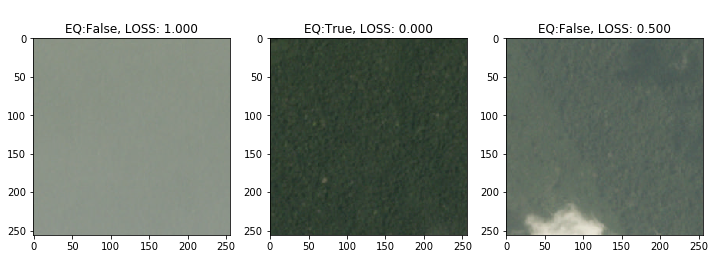

In [313]:
display_random(3)


image: train_18373
vec: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: True
dist: 0.000

image: train_34605
vec: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: True
dist: 0.000

image: train_12328
vec: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 0.184


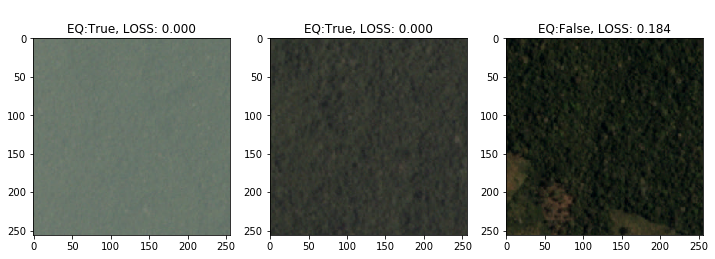

In [314]:
display_random(3)


image: train_13291
vec: [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 0.368

image: train_15486
vec: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: False
dist: 0.500

image: train_35150
vec: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
prd: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
equal: True
dist: 0.000


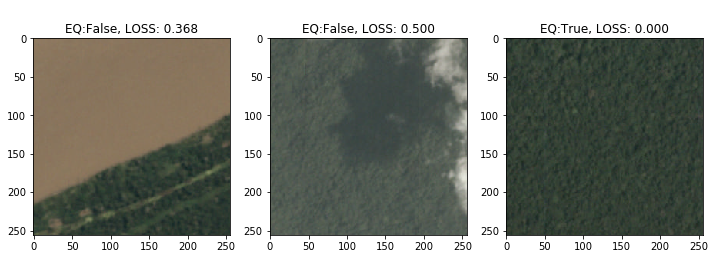

In [315]:
display_random(3)